<a href="https://colab.research.google.com/github/Agbeli/Amino_acid_sequence/blob/main/Amino_acid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### InstaDeep Enzyme Classification

- In this project, I am to classify amino acid sequences given their corresponding labels. 
- This is biological problem with aim of using ML algorithms to solve sequence 
prediction.
- Lastly, this is an open challenge by Instadeep.  

In [ ]:
### mount my drive to colab in order to have access to the dataset. 
from google.colab import drive 
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
### change working directory to the data folder. 
%cd "/content/drive/MyDrive/InstaDeep_projects"

/content/drive/MyDrive/InstaDeep_projects


In [ ]:
pip install -U imbalanced-learn

     |████████████████████████████████| 174kB 5.7MB/s 
     |████████████████████████████████| 22.2MB 2.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
!curl ipecho.net/plain

35.189.181.23

In [ ]:
### load the necessary libraries 
import pandas as pd 
import numpy as np 
import os 
from matplotlib import pyplot as plt 
from glob import glob 
import scipy 
import warnings 
import sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
import seaborn 
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

plt.style.use("ggplot")
warnings.filterwarnings("ignore")
%matplotlib inline 

In [ ]:
%ls -sh

total 456M
2.5M SampleSubmission.csv   97M Test.csv  357M Train.csv  485K Untitled0.ipynb


In [ ]:
### load the dataset for both train and test set. 
trainset1 = pd.read_csv("Train.csv")
testset = pd.read_csv("Test.csv")

### Check the first five rows of the train dataset

In [ ]:
trainset.head(5)

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16
3,0003XVE3,MKNTSLSTTLTMNDTIAAIATPLGKGAISIIKISGHNALNILKQLT...,creature3,class12
4,00049BS0,MGNRLTKIYTKTGDSGLTGLADGSRTEKDSLRIFVIGDVDELNSLL...,creature8,class13


In [ ]:
### data shape:
from pprint import pprint
pprint(f"Shape of train: {trainset.shape} |shape for test: {testset.shape}")

'Shape of train: (858777, 4) |shape for test: (253146, 3)'


### Use subset of the dataset

In [ ]:
### alternative manner to handle the dataset
trainset = trainset1[["SEQUENCE","LABEL"]]

In [ ]:
### Using 75 percent of the dataset due to limited RAM 
trainset = trainset1.sample(frac=0.65,replace=False,random_state=43)

In [ ]:
del trainset1

### Exploratory Data Analysis 


- We need to understand the nature of the dataset before I think of how I can handle them. 

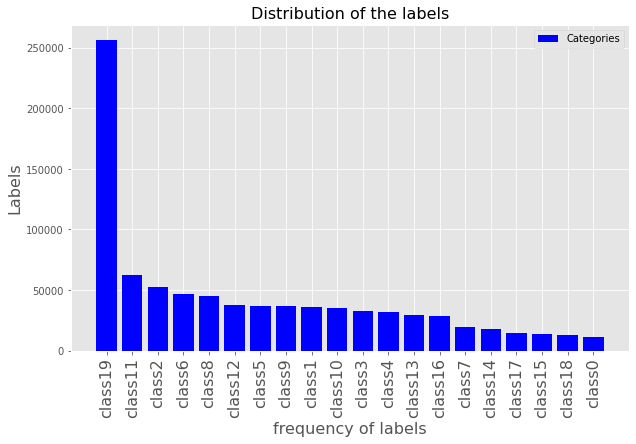

In [ ]:
#### visualize the total number labels 
from collections import Counter
d = Counter(trainset.LABEL)
d = sorted(d.items(),key=lambda x:x[1],reverse=True)
x , y = zip(*d)  ## unpack the 

plt.figure(figsize=(10,6))
plt.bar(x,y,label="Categories",color="blue")
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16, rotation=45)
plt.title("Distribution of the labels",fontsize=16)
plt.ylabel("Labels",fontsize=16)
plt.xlabel("frequency of labels",fontsize=16)
plt.legend(loc="best")
plt.show()

In [ ]:
### statistics of the len of the sequence 
trainset.SEQUENCE.map(lambda x : len(x)).describe()

count    858777.000000
mean        407.550355
std         211.880784
min          16.000000
25%         263.000000
50%         381.000000
75%         481.000000
max        1234.000000
Name: SEQUENCE, dtype: float64

### Distribution of sequence length for each label

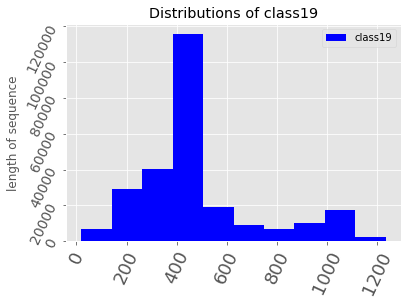

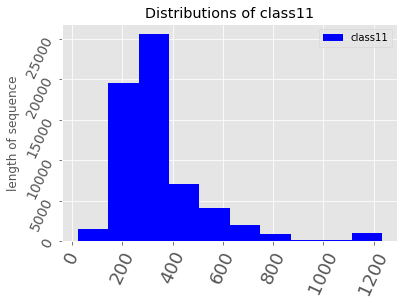

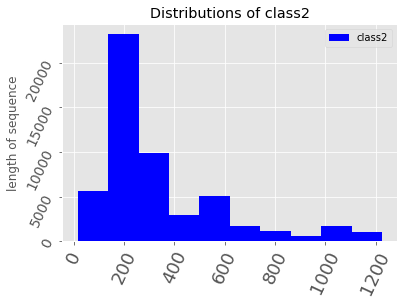

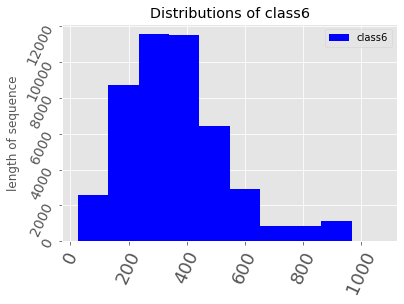

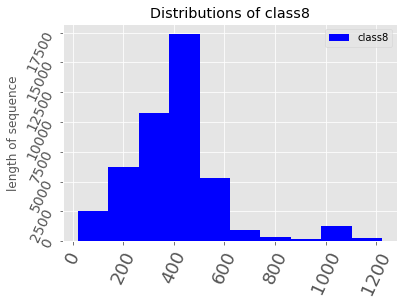

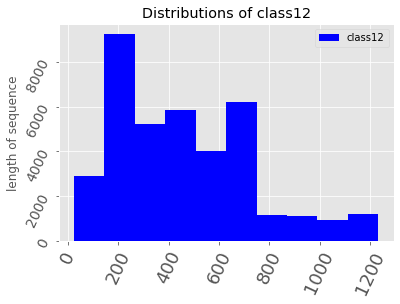

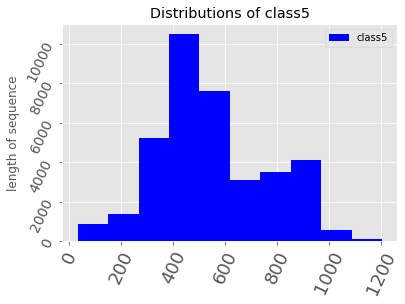

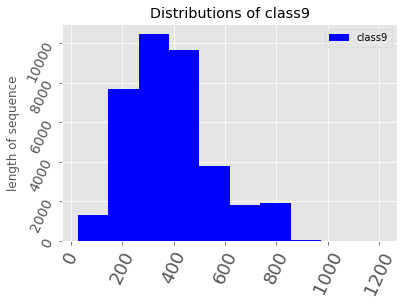

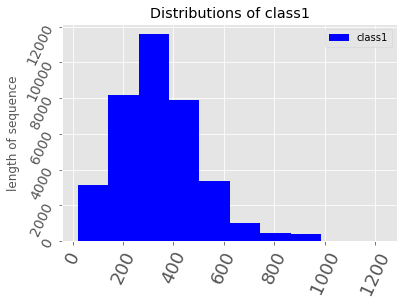

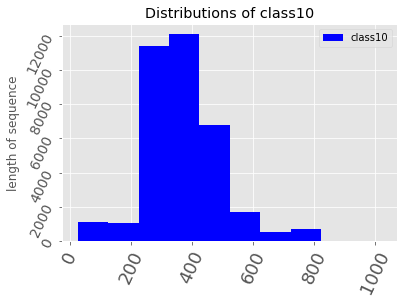

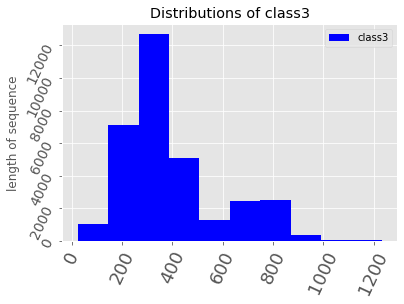

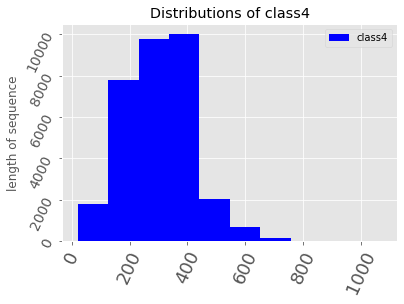

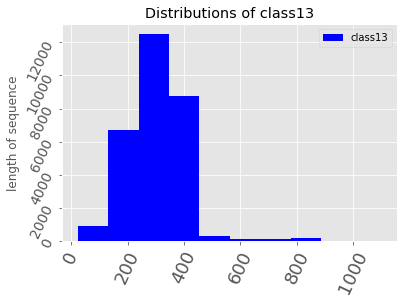

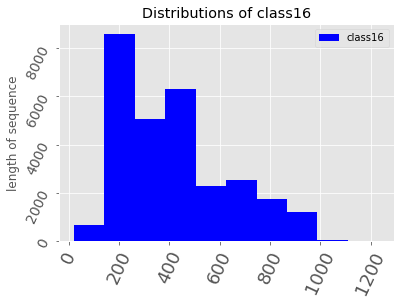

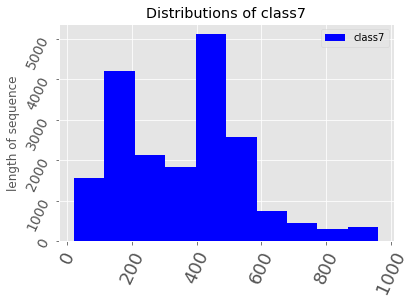

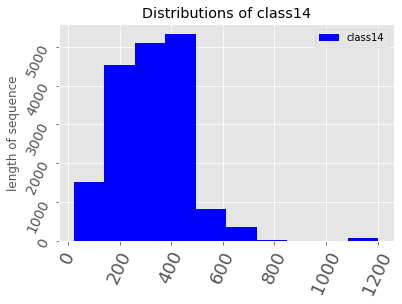

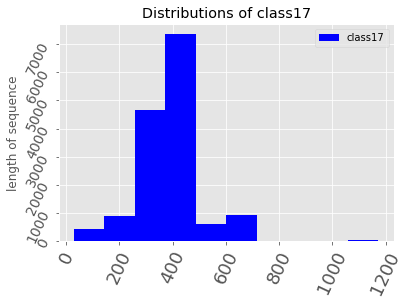

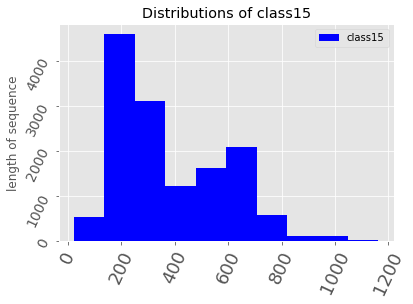

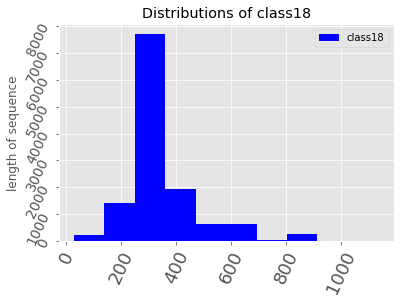

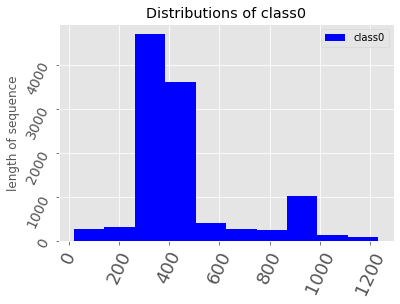

In [ ]:
### visualize the disribution of the label given the sequence. 
def analyse_sequence(df,label):
  df = df.copy()
  results = df[df["LABEL"]==label]["SEQUENCE"].str.len()
  plt.hist(results,label=label,color="blue")
  plt.title(f"Distributions of {label}")
  plt.ylabel("length of sequence")
  plt.xticks(fontsize=18,rotation=65)
  plt.yticks(fontsize=14,rotation=65)
  plt.legend(loc="best")
  plt.show()


for lab in x:
  analyse_sequence(trainset,lab)

### Preprocess the data

- After have insight about the dataset, now we preprocess them to fit the model I want to develop. 
- There is some level of imbalance in the dataset. 
- I have to find a strategy to solve the data imbalance problem. 
  - One possible way is consider cross-validation. 
  - Another approach to under the majority class.

In [ ]:
### create target from the label 
from collections import Counter
d = Counter(trainset.LABEL)
d = sorted(d.items(),key=lambda x:x[1],reverse=True)
x , y = zip(*d)  ## unpack the 

target = dict()

for lab in x:
  target[lab] = int(lab[5:])

trainset["TARGET"] = trainset.LABEL.map(target)

In [ ]:
trainset.head()

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL,TARGET
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11,11
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13,13
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16,16
3,0003XVE3,MKNTSLSTTLTMNDTIAAIATPLGKGAISIIKISGHNALNILKQLT...,creature3,class12,12
4,00049BS0,MGNRLTKIYTKTGDSGLTGLADGSRTEKDSLRIFVIGDVDELNSLL...,creature8,class13,13


### Define A-mer function

- At this stage, we have to define kmer function for generating subsequence of 
characters.

- The equation defined below shows the sequence length of the number subsequences. 

- Generating these subsequences one have to consider the length of the sequence. 


$$A = L - k + 1$$
  - A = length of subsequence 
  - L = length of the sequence. 
  - k = size of a subsequence. 

In [ ]:
### kmer text generation
def kmer(seq,size=4):
  seq = seq.lower()
  seq_text = [seq[i:i+size] for i in range(len(seq) - size + 1)]
  text = " ".join(seq_text)
  return text

In [ ]:
### Test the kmer 
kmer(seq="MPWQELSITVPHEYVEPI")

'MPWQ PWQE WQEL QELS ELSI LSIT SITV ITVP TVPH VPHE PHEY HEYV EYVE YVEP VEPI'

In [ ]:
trainset["NEW_SEQUENCE"] = trainset.SEQUENCE.apply(kmer)

In [ ]:
trainset.head()

,SEQUENCE_ID,SEQUENCE,CREATURE,LABEL,TARGET,NEW_SEQUENCE
0,00011UBJ,MPWQELSITVPHEYVEPISYLFGRYGKGVSTELAGNGQVLLRTYLT...,creature9,class11,11,MPWQ PWQE WQEL QELS ELSI LSIT SITV ITVP TVPH V...
1,0001HZ3P,MGKLVIGSRGSELALWQANHIKERLKKECLIESEIQIVKTKGDKIL...,creature3,class13,13,MGKL GKLV KLVI LVIG VIGS IGSR GSRG SRGS RGSE G...
2,0003NJDO,MFIVAVLMLAFLIFVHELGHFTIARICGVKVEVFSIGFGKKLCFFK...,creature3,class16,16,MFIV FIVA IVAV VAVL AVLM VLML LMLA MLAF LAFL A...
3,0003XVE3,MKNTSLSTTLTMNDTIAAIATPLGKGAISIIKISGHNALNILKQLT...,creature3,class12,12,MKNT KNTS NTSL TSLS SLST LSTT STTL TTLT TLTM L...
4,00049BS0,MGNRLTKIYTKTGDSGLTGLADGSRTEKDSLRIFVIGDVDELNSLL...,creature8,class13,13,MGNR GNRL NRLT RLTK LTKI TKIY KIYT IYTK YTKT T...


In [ ]:
### The use countvectorizer 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

vectorizer = CountVectorizer(input='content',binary=False,ngram_range=(1,1))
trainset_vec = vectorizer.fit_transform(trainset.NEW_SEQUENCE)

### Baseline model 

In [ ]:
Xtrain , Xtest, ytrain , ytest = train_test_split(trainset_vec,trainset.LABEL,random_state=42,test_size=0.15)

In [ ]:
del trainset_vec ,trainset

In [ ]:
##### make a pipeline for prediction 
####  from imblearn.pipeline import Pipeline 
over = SMOTE()
undersample = RandomUnderSampler(sampling_strategy='majority')
oversample = RandomOverSampler(sampling_strategy="minority")

In [ ]:
x_train_res, y_train_res = oversample.fit_resample(Xtrain, ytrain)

In [ ]:
### free up space on the memory 
del Xtrain , ytrain

### Logistic Regression classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

logistic = LogisticRegression()
logistic.fit(x_train_res,y_train_res)

In [ ]:
#### Evaluate the performance 
print(f"logistic model accuracy score : {accuracy_score(ytest,logistic.predict(Xtest)):.2}")

logistic model accuracy score : 0.95


In [ ]:
### support vector machine 
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score,f1_score,precision_score
svm = SVC(gamma="auto")
svm.fit(x_train_res,y_train_res)

In [ ]:
del x_train_res,y_train_res

In [ ]:
#### Evaluate the performance 
print(f"svm model accuracy score : {accuracy_score(ytest,svm.predict(Xtest)):.2}")

In [ ]:
### delete them after training. 
del ytest,Xtest

### Cross-validation score. 

In [ ]:
naive_model = MultinomialNB()
#scores = cross_val_score(naive_model, trainset_vec, trainset.TARGET, cv=4)
print(f"{scores.mean():.2} accuracy with a standard deviation of {scores.std():.2}")

0.84 accuracy with a standard deviation of 0.00093


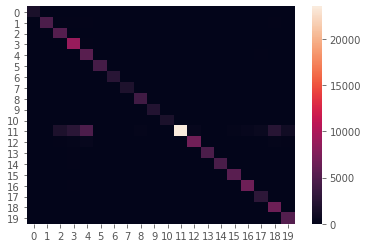

In [ ]:
from sklearn.metrics import  confusion_matrix,accuracy_score

seaborn.heatmap(confusion_matrix(ytest,naive_model.predict(Xtest)))

In [ ]:
del Xtrain , Xtest, ytrain , ytest 

### Prediction Phase:

In [ ]:
testset.head()

,SEQUENCE_ID,SEQUENCE,CREATURE
0,000LRRAI,MKLPVKRYAVAAIVALGVSMAPGELRTSPEAQIKIATREECRATPY...,creature7
1,000O8L4W,MKISVFGSGYVGLVQAAVLAEVGHDVVCMDIDKVKVEQLSQGQVHI...,creature6
2,000UKB5J,MTMKVGFIGLGIMGKPMSKNLLKAGYSLVVADRNPEAIADVIAAGA...,creature7
3,00111SLH,MTVSLSRLERQLGYTFKDQELMILALTHRSFAGRNNERLEFLGDAI...,creature6
4,001ELB0A,MSKIRVLSVDDSALMRQIMTEIINSHSDMEMVATAPDPLVARDLIK...,creature7


In [ ]:
testset["NEW_SEQUENCE"] = testset.SEQUENCE.apply(kmer)

In [ ]:
testset_vec = vectorizer.transform(testset.NEW_SEQUENCE)

In [ ]:
pred = svm.predict(testset_vec)

In [ ]:
del testset_vec

In [ ]:
pred[:10]

array(['class16', 'class10', 'class10', 'class2', 'class2', 'class2',
       'class19', 'class19', 'class19', 'class17'], dtype=object)

In [ ]:
sub = pd.read_csv("SampleSubmission.csv")
sub.head()

,SEQUENCE_ID,LABEL
0,000LRRAI,NaN
1,000O8L4W,NaN
2,000UKB5J,NaN
3,00111SLH,NaN
4,001ELB0A,NaN


In [ ]:
sub["LABEL"] = pred

In [ ]:
sub.head()

,SEQUENCE_ID,LABEL
0,000LRRAI,class11
1,000O8L4W,class10
2,000UKB5J,class10
3,00111SLH,class2
4,001ELB0A,class2


In [ ]:
sub.to_csv("submission6.csv",index=False)

### BERT embeddings 

- At this stage I want to consider the bert embeddings to access to the continuous vectors. 

In [ ]:
!pip install bert-serving-server  # server
!pip install bert-serving-client  # client, independent of `bert-serving-server`

     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=cbf4779ef3a83a54087c924e2e303094dbf8a6475dbabe7fef0e3dfead5fc244
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip

--2021-01-02 00:49:09--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  42.0MB/s    in 8.1s    

2021-01-02 00:49:18 (48.0 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
!bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=1 -max_seq_len 50

2021-01-02 00:54:55.123988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/usr/local/lib/python3.6/dist-packages/bert_serving/server/helper.py:176: UserWarning: Tensorflow 2.4.0 is not tested! It may or may not work. Feel free to submit an issue at https://github.com/hanxiao/bert-as-service/issues/
  'Feel free to submit an issue at https://github.com/hanxiao/bert-as-service/issues/' % tf.__version__)
usage: /usr/local/bin/bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=1 -max_seq_len 50
                 ARG   VALUE
__________________________________________________
           ckpt_name = bert_model.ckpt
         config_name = bert_config.json
                cors = *
                 cpu = False
          device_map = []
       do_lower_case = True
  fixed_embed_length = False
                fp16 = False
 gpu_memory_fraction = 0.5
       graph_tmp_dir = None
    http_max_connect = 10
          

In [ ]:
from bert_serving.client import BertClient

In [ ]:
!nohup bert-serving-start -pooling_strategy NONE -max_seq_len 128 -model_dir ./multi_cased_L-12_H-768_A-12 > out.file 2>&1 &

In [ ]:
bc = BertClient().encode(["I love data science and analytics vidhya."])
print(bc)

In [ ]:
# df = trainset
# df["kfold"] = -1
# df = df.sample(frac=1).reset_index(drop=True)
# kf = StratifiedKFold(n_splits=5)
# for fold, (trn_, val_) in enumerate(kf.split(X=df, y=df.target.values)):
#   print(len(trn_), len(val_))
#   df.loc[val_, 'kfold'] = fold

# df.to_csv("train_folds.csv", index=False)